# Battery Fast-Charging Optimization

1. Import the necessary libraries in Pytorch

In [1]:
#Import libraries

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

2. Import the experimental data to use as training data for the ANN. In `input_data_save.txt`, the first column represents the porosity of the anode, and the second column represents the porosity of the cathode. In 
`cap_data_save.txt`, the first column contains the battery areal capacity.

In [2]:
#Import the experimental data
input_data_raw1 = np.loadtxt('data/input_data_save.txt')
cap_data_raw1 = np.loadtxt('data/cap_data_save.txt') 

In [3]:
cap_data_raw1[:5]

array([18.76968 , 16.126228, 16.950027, 16.344672, 18.447988])

In [4]:
input_data_raw1[:5]

array([[0.61662566, 0.53994316],
       [0.65760637, 0.42037422],
       [0.30714407, 0.61521121],
       [0.66101914, 0.48977151],
       [0.53456166, 0.4078272 ]])

3. Convert the training data to PyTorch tensor format.

In [5]:
# Convert the training data to PyTorch tensors
X_train_tensor_raw = torch.tensor(input_data_raw1, dtype=torch.float32)
y_train_tensor_raw = torch.tensor(cap_data_raw1, dtype=torch.float32)

4. Normalize the training data to ensure that the values are within the range [0, 1].

In [6]:
def normalize_tensor(tensor, max_val, min_val):
    return (tensor-min_val)/(max_val-min_val)

X_train_epsneg_raw1 = X_train_tensor_raw[:,0]
X_train_epspos_raw1 = X_train_tensor_raw[:,1]

max_epsneg = torch.max(X_train_epsneg_raw1)
min_epsneg = torch.min(X_train_epsneg_raw1)

max_epspos = torch.max(X_train_epspos_raw1)
min_epspos = torch.min(X_train_epspos_raw1)

X_train_epsneg_norm1 = normalize_tensor(X_train_epsneg_raw1, max_epsneg, min_epsneg)
X_train_epspos_norm1 = normalize_tensor(X_train_epspos_raw1, max_epspos, min_epspos)
X_train = torch.stack((X_train_epsneg_norm1, X_train_epspos_raw1), dim=1)

y_train_tensor = y_train_tensor_raw
max_y = torch.max(y_train_tensor)
min_y = torch.min(y_train_tensor)
y_train_norm = normalize_tensor(y_train_tensor, max_y, min_y)
y_train = y_train_norm.reshape(200,1)

5. Set up the ANN machine learning model to represent the relationship between the normalized electrode porosities and the battery areal capacity.

In [7]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        #Define layers
        self.layer1 = nn.Linear(2, 15) # Input layer (2 inputs) to first hidden layer (15 neurons)
        self.layer2 = nn.Linear(15, 5) # First hidden layer (15 neurons) to second hidden layer (5 neurons)
        self.layer3 = nn.Linear(5, 1) # Second hidden layer (5 neurons) to output layer (1 output)

        #Define the activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        #Forward pass through the network
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [8]:
# Instantiate the model
model = ANN()

# Define the loss function (Mean Squared Error for regression)
criterion = nn.MSELoss()

# Define the optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.05)

6. Train the ANN machine learning model.

In [9]:
# Number of epochs for training
num_epochs = 20000

for epoch in range(num_epochs):
    # Forward pass: compute the model output
    outputs = model(X_train)

    # Compute the loss
    loss = criterion(outputs, y_train)

    # Backward pass: compute the gradients
    optimizer.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch+1)%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], loss:{loss.item():.4f}')

Epoch [100/20000], loss:0.0704
Epoch [200/20000], loss:0.0684
Epoch [300/20000], loss:0.0654
Epoch [400/20000], loss:0.0609
Epoch [500/20000], loss:0.0546
Epoch [600/20000], loss:0.0473
Epoch [700/20000], loss:0.0406
Epoch [800/20000], loss:0.0354
Epoch [900/20000], loss:0.0320
Epoch [1000/20000], loss:0.0299
Epoch [1100/20000], loss:0.0284
Epoch [1200/20000], loss:0.0274
Epoch [1300/20000], loss:0.0265
Epoch [1400/20000], loss:0.0258
Epoch [1500/20000], loss:0.0253
Epoch [1600/20000], loss:0.0247
Epoch [1700/20000], loss:0.0243
Epoch [1800/20000], loss:0.0238
Epoch [1900/20000], loss:0.0233
Epoch [2000/20000], loss:0.0228
Epoch [2100/20000], loss:0.0223
Epoch [2200/20000], loss:0.0218
Epoch [2300/20000], loss:0.0214
Epoch [2400/20000], loss:0.0209
Epoch [2500/20000], loss:0.0203
Epoch [2600/20000], loss:0.0197
Epoch [2700/20000], loss:0.0190
Epoch [2800/20000], loss:0.0182
Epoch [2900/20000], loss:0.0172
Epoch [3000/20000], loss:0.0163
Epoch [3100/20000], loss:0.0155
Epoch [3200/20000

7. Set up a gradient-based optimization algorithm to optimize the electrode porosities for achieving the highest battery areal capacity after fast charging, based on the trained ANN surrogate model. Specifically, ensure that the values of the two normalized design variables are within the range [0, 1].

In [13]:
# Define the function to optimize
def objective_function(x):
    tensor1 = x[0]    # 1 represents the anode porosity 
    tensor2 = x[1]    # 2 represents the cathode porosity
    x_input = torch.stack((tensor1, tensor2), dim=0)
    return model(x_input)

# Initialize the inputs (parameters to optimize)
val0 = torch.rand(1)    # an initial guess of anode porosity (normalized)
val1 = torch.rand(1)    # an initial guess of cathode porosity (normalized)
x = torch.tensor([val0, val1], requires_grad=True)

# Define the optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD([x], lr=0.01)  # lr is the learning rate

# Number of optimization steps
num_steps = 100

# Lists to store the evolution of x[0], x[1], and loss
x0_values = []
x1_values = []

# Optimization loop
for step in range(num_steps):
    # Zero the gradients from the previous step
    optimizer.zero_grad()

    # Compute the objective function
    result = objective_function(x)
    loss = -result[0]

    # Compute the gradients (backward pass)
    loss.backward()

    # Update the parameters using the optimizer
    optimizer.step()

    # Apply the constraints to keep x[0] and x[1] within [0, 1]
    with torch.no_grad():
        x.clamp_(0, 1)  # In-place operation to clamp x within [0, 1]

    # Store the current values of x[0], x[1], and loss
    x0_values.append(x[0].item())
    x1_values.append(x[1].item())

    # Print the current value of the loss and parameters
    print(f"Step {step + 1}: x = {x.detach().numpy()}, Loss = {loss.item()}")

# Final optimized values
print(f"Optimized x: {x.detach().numpy()}")
print(f"Final Loss: {objective_function(x).item()}")

Step 1: x = [0.21186022 0.31719613], Loss = -0.1302674114704132
Step 2: x = [0.22778958 0.3513925 ], Loss = -0.33305492997169495
Step 3: x = [0.24371894 0.38558888], Loss = -0.4753686487674713
Step 4: x = [0.2596483  0.41978526], Loss = -0.6176823377609253
Step 5: x = [0.27557766 0.45398164], Loss = -0.7599959373474121
Step 6: x = [0.29150704 0.488178  ], Loss = -0.9023096561431885
Step 7: x = [0.31833115 0.49045348], Loss = -1.0122780799865723
Step 8: x = [0.331884   0.47952017], Loss = -1.0754508972167969
Step 9: x = [0.32514885 0.5025767 ], Loss = -1.0722769498825073
Step 10: x = [0.3387017 0.4916434], Loss = -1.0714361667633057
Step 11: x = [0.34339097 0.5066797 ], Loss = -1.0952407121658325
Step 12: x = [0.35694382 0.4957464 ], Loss = -1.091673493385315
Step 13: x = [0.35020867 0.51880294], Loss = -1.092810869216919
Step 14: x = [0.3637615 0.5078696], Loss = -1.0876585245132446
Step 15: x = [0.36588994 0.50495654], Loss = -1.102761149406433
Step 16: x = [0.36801836 0.5020435 ], Lo

8. Plot the evolution of the anode porosity, x[0], and the cathode porosity, x[1], throughout the optimization process.

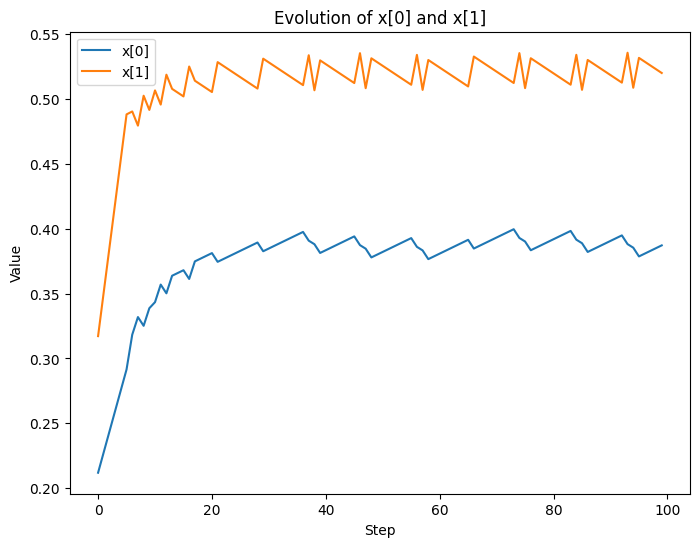

In [14]:
# Plotting the evolution of x[0] and x[1]
plt.figure(figsize=(8, 6))
plt.plot(x0_values, label='x[0]')
plt.plot(x1_values, label='x[1]')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Evolution of x[0] and x[1]')
plt.legend()
plt.show()

9. De-normalize the anode and cathode porosities, as well as the battery areal capacity, to return them to their original scale.

In [17]:
# define the de-normalization function
def de_normalize_tensor(tensor, max_val, min_val):
    return tensor * (max_val - min_val) + min_val
    
# de-normalize the porosity of anode and cathode
value_real0 = de_normalize_tensor(x[0], max_epsneg, min_epsneg)
print(f"Optimized result of anode porosity: {value_real0}")
value_real1 = de_normalize_tensor(x[1], max_epspos, min_epspos)
print(f"Optimized result of cathode porosity: {value_real1}")

# de-normalize the capacity value (C/m^2)
y = model(x)
cap_optim = de_normalize_tensor(y[0], max_y, min_y)
print(f"Optimized battery areal capacity: {cap_optim}")

Optimized result of anode porosity: 0.4248338043689728
Optimized result of cathode porosity: 0.487179696559906
Optimized battery areal capacity: 24.93080711364746
